In [9]:
import sys
import os
import warnings
import glob
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

# Go up one directory from 'notebooks/' to project root
project_root = os.path.abspath('..')
sys.path.append(project_root)

os.getcwd()

'/home/echerif/Projects/SemiSup_Project/Semi_supervised_template/notebooks'

In [3]:
from src.utils_all import *
from src.utils_data import *
from src.transformation_utils import *

from src.AE_RTM.AE_RTM_architectures import *
from src.AE_RTM.trainer_ae_rtm import *

# #### Model definition ###
# from src.rtm_torch.Resources.PROSAIL.call_model import *
# from src.rtm_torch.rtm import RTM

In [ ]:
# from scipy.signal import savgol_filter
# from sklearn.preprocessing import PowerTransformer
# import random

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
import wandb 
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [6]:
seed = 155
seed_all(seed=seed)

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

In [13]:
######## Data ########
ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]
percentage_tr = 1
batch_size = 128 
lr = 1e-3

directory_path = os.path.join(project_root, "Splits")
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))
file_paths = file_paths[:int(percentage_tr*len(file_paths))]

path_data_lb = os.path.join(project_root, "Datasets/50SHIFT_all_lb_prosailPro.csv") ##50SHIFT_all_lb_prosailPro 49_all_lb_prosailPro

path_data_lb

'/home/echerif/Projects/SemiSup_Project/Semi_supervised_template/Datasets/50SHIFT_all_lb_prosailPro.csv'

In [ ]:
################ Labeled ###############
db_lb_all = pd.read_csv(path_data_lb, low_memory=False).drop(['Unnamed: 0'], axis=1)   

### external
groups = db_lb_all.groupby('dataset')

val_ext_idx = list(groups.get_group(32).index)+list(groups.get_group(3).index)+list(groups.get_group(50).index)
ext_all = db_lb_all.loc[val_ext_idx,:] ##
db_lb_all.drop(val_ext_idx, inplace=True)

X_labeled, y_labeled, _ = data_prep_db(db_lb_all, ls_tr, weight_sample=True)
metadata = db_lb_all.iloc[:, :8]  # The metadata (dataset of origin)


red_ed = X_labeled.loc[:,750]
red_end = X_labeled.loc[:,1300]
red1000_ = X_labeled.loc[:,1000]

idx = X_labeled[(red_end>red1000_) & (red_ed>red1000_)].index

if(len(idx)>0):
    # X_labeled.loc[idx,:].T.plot(legend=False)
    X_labeled.drop(idx, inplace=True)
    y_labeled.drop(idx, inplace=True)
    metadata.drop(idx, inplace=True)


# Split labeled data into train (80%), validation (20%)
X_train, X_val= train_test_split(X_labeled, test_size=0.2, stratify=metadata.dataset, random_state=300)

y_train = y_labeled.loc[X_train.index,:]
y_val = y_labeled.loc[X_val.index,:]

meta_train = metadata.loc[X_train.index,:]
meta_val = metadata.loc[X_val.index,:]

ext_val_x = feature_preparation(ext_all.loc[:, '400':'2500']).loc[:, 400:2450]
ext_val_y = ext_all[ls_tr] # Traits_tr 

# # Create the dataset
# train_dataset = SpectraDataset(X_train, y_train, meta_train, augmentation=True, aug_prob=0.8)
# # Define DataLoader with the custom collate function for fair upsampling
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SpectraDataset(X_train=X_val, y_train=y_val, meta_train=meta_val, augmentation=False)
# Create DataLoader for the test dataset
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # # Create the dataset
# untrain_dataset = MultiFileAugmentedCSVDataset(file_paths, chunk_size=1000, augmentation=True, aug_prob=0.5, scale=False) ## No scaling of spectra
# unlabeled_loader = DataLoader(untrain_dataset, batch_size=batch_size, 
#                         shuffle=True
#                        )

######## Transferbility ####
# Validation dataset
x_p_val = torch.tensor(ext_val_x.values, dtype=torch.float)#.unsqueeze(dim=1) ##ext_val_x.values scaler_spectra.transform(ext_val_x.iloc[:,:-1])
lb_p_val = torch.tensor(ext_val_y.values,dtype=torch.float)

external_dataset = TensorDataset(x_p_val, lb_p_val) # x_p_val
ext_loader = DataLoader(external_dataset, batch_size=128)

In [ ]:
perc = 100

# scaler_list = save_scaler(y_train, standardize=True, scale=True)
main_path = '/home/mila/e/eya.cherif/scratch/ae_rtm/checkpoints_AE_RTM_250307_0633_{}labels_240'.format(perc, seed)

# open a file, where you stored the pickled data
file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 

# dump information to that file
scaler_list = pickle.load(file)

In [ ]:
######

settings_dict = {
    'epochs': 500,
    'train_loader': None,
    'unlabeled_loader' : None,#unlabeled_loader,
    'valid_loader': valid_loader,
    'checkpoint_dir': None, #checkpoint_dir,
    'batch_size': batch_size,
    'learning_rate': lr,
    'early_stop': True,
    'patience': 10,
    'scaler_model': scaler_list,
    'input_shape' : 1721,
    'log_epoch' : 10,
    'lamb': 1e0,
    'loss_recons_criterion': CosineSimilarityLoss(), #CosineSimilarityLoss() #mse_loss
    # 'logger': wandb
}


sets = Settings_ae()
sets.update_from_dict(settings_dict)

test_reg = Trainer_AE_RTM(sets)
# test_reg.model = AE_RTM_corr(input_shape, n_lb, scaler_list=scaler_list)

test_reg.dataset_setup()

path_model = open(os.path.join(main_path, 'best_model.h5'), 'rb')  #checkpoints_AE_RTM_240930_0154_100labels checkpoints_AE_RTM_240930_1325_100labels  checkpoints_AE_RTM_241001_0551_20.0labels
test_reg.model_setup()

test_reg.model = torch.load(path_model)

test_reg.model.eval()

AE_RTM_corr(
  (encoder): Sequential(
    (0): Linear(in_features=1721, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=8, bias=True)
  )
  (correction): Sequential(
    (0): Linear(in_features=2101, out_features=8404, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8404, out_features=2101, bias=True)
  )
)

In [13]:
# Calculate the number of trainable parameters
num_trainable_params = sum(p.numel() for p in test_reg.model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 35437289


In [77]:
plt.rcParams['lines.linewidth'] = 2

tot_val = 0
preds = torch.empty(0,8).to(device)
ori = torch.empty(0,8).to(device)

test_reg.model.eval()

with torch.no_grad():
    for batch_idx, val_sample in enumerate(valid_loader):
        data_val, lb_bx_val, _ = val_sample
        
        lb_bx_val = lb_bx_val.to(device).float()
        data_val = data_val.squeeze().float().to(device)
        
        x_val, out_val = test_reg.model(data_val)
        output_val = out_val.data[:,list(range(951))+list(range(1031,1401))+list(range(1651,2051))]

        val_pred = out_val.data[:,list(range(951))+list(range(1031,1401))+list(range(1651,2051))]
        
        ori = torch.cat((ori.data,lb_bx_val.data), dim=0)
        preds = torch.cat((preds.data,x_val[:,:].data), dim=0)


if(test_reg.settings.scaler_model is not None):
    # ori = test_reg.transformation_layer_inv(ori) ### shoud keep the sam eorder of labels !!!
    preds = test_reg.transformation_layer_inv(preds) ### shoud keep the sam eorder of labels !!!
    

ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(ori_lb.describe())

df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])#[original_dict.keys()#
df_tr_val['cbc'] = df_tr_val['cm']-df_tr_val['cp']
display(df_tr_val.describe())

,cab,cw,cm,LAI,cp,cbc,car,anth
count,396.000000,424.000000,736.000000,284.000000,555.000000,555.000000,325.000000,73.000000
mean,37.838181,0.013924,0.008714,3.246530,0.000769,0.008235,8.163689,1.328033
std,13.576089,0.008998,0.006341,1.769485,0.000441,0.006393,2.867902,0.435457
min,4.448305,0.000133,0.000031,0.080000,0.000007,0.000024,1.182576,0.668249
25%,26.817780,0.008742,0.005205,1.784167,0.000501,0.005193,6.044010,1.009537
50%,36.388645,0.011581,0.007490,3.271715,0.000746,0.006759,8.066246,1.219571
75%,47.984413,0.017414,0.010012,4.589347,0.000994,0.009147,9.818449,1.601554
max,78.123940,0.056263,0.049981,7.136380,0.004204,0.045777,19.568256,2.981117


,cab,cw,cm,LAI,cp,cbc,car,anth
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,37.007187,0.015468,0.008076,3.650589,0.000700,0.007376,8.486869,1.235763
std,11.705013,0.008038,0.005338,1.391503,0.000305,0.005066,2.591802,0.454411
min,11.632229,0.000485,0.000108,0.040720,0.000015,0.000093,2.955859,0.494877
25%,27.988508,0.010472,0.005408,2.745076,0.000529,0.004874,6.705910,0.892549
50%,35.753990,0.014096,0.007090,3.780728,0.000693,0.006361,7.991536,1.144192
75%,46.551178,0.017835,0.008947,4.659650,0.000838,0.008208,9.992737,1.516337
max,61.200920,0.061918,0.046792,7.292021,0.002809,0.044327,15.970016,2.725833


In [78]:
val_mertics = eval_metrics(ori_lb, df_tr_val)
val_mertics

,r2_score,RMSE,nRMSE (%),MAE,Bias
cab,0.520794,9.386131,17.269504,6.788890,1.315834
cw,0.508588,0.006300,14.912525,0.003868,-0.000181
cm,0.567321,0.004168,12.185694,0.002534,0.000319
LAI,0.390895,1.378564,20.479321,1.017793,-0.120466
cp,0.512991,0.000308,12.151347,0.000205,0.000014
cbc,0.599283,0.004043,11.926695,0.002420,0.000115
car,0.427026,2.167517,15.296562,1.512912,0.434301
anth,0.194826,0.388056,20.000144,0.260146,0.140437


In [79]:
# from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
# import math
# import seaborn as sns


# size = 5.7
# quantile_vis = 1.0
# figsize = (10,4)

# # obs_pf = val_y
# test_tr = list(ori_lb.columns)

# plt.rc('font', size=size) #5.7
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.linewidth'] = 0.5

# a = 2 # number of rows
# b = 5  # number of columns
# c = 1  # initialize plot counter

# fig = plt.figure(figsize = figsize,dpi=300 ,constrained_layout=True)


# for tr in range(len(test_tr)):
    
#     # test_sample = torch.tensor(val_x.astype(np.float32).values).unsqueeze(dim=1).to(gpu)
#     # pred = scaler_list.inverse_transform(D(test_sample)[0].cpu().detach().numpy())[:,tr]
#     # true = val_y[Traits[tr]]#val_y
#     pred = df_tr_val.copy().values[:,tr]
#     true = ori_lb.copy()[test_tr[tr]]
    
#     norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))
    
#     f = pd.DataFrame(pred)[0]
#     y = true.reset_index(drop=True)
    
#     idx = np.union1d(f[f.isna()].index,y[y.isna()].index)
    
#     f.drop(idx, axis = 0, inplace=True)
#     y.drop(idx, axis = 0, inplace=True)
    
#     r2 = r2_score(y,f)
#     nrmse = math.sqrt(mean_squared_error(y,f))/norm
#     nmae = mean_absolute_error(y,f)/norm

#     ax1 = plt.subplot(a, b, c)
#     plt.axis('square')
    
#     lim_max = min(f.quantile(quantile_vis),y.quantile(quantile_vis)) 
#     lim_min = max(f.quantile(1-quantile_vis),y.quantile(1-quantile_vis))
    
#     #######
#     ax1.set_xlim(lim_min,lim_max)
#     ax1.set_ylim(ax1.get_xlim())
#     ax1.set_aspect('equal', adjustable='box')

#     sns.lineplot(x=(lim_min,lim_max), y=(lim_min,lim_max), ax = ax1, color='black',legend='full', linestyle='dashed')

#     sns.regplot(x= f, color='b', y=y,fit_reg= True,ax=ax1, ci=False, scatter_kws={"color": "blue", 'alpha':0.3})
#     # sns.regplot(x= f, y=y, color='b', fit_reg= True, ax=ax1, scatter=False)

#     ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    
#     ax1.annotate(ann,
#     xy=(0.55,0.01),
#     xycoords='axes fraction',
#     horizontalalignment='left',
#     verticalalignment='bottom',size=size)

#     ann = test_tr[tr]
#     ax1.set_title(ann, y=1.1, pad=-5, fontdict = {'fontsize':size,
#     'horizontalalignment': 'center', 'fontweight':'bold'})
    
#     plt.xlabel(" ")
#     plt.ylabel(" ")
    
#     c+=1

# fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
# fig.supylabel('Observations', size=8, fontweight='bold', ha='center')


In [80]:
############## Trannsfer

In [14]:
plt.rcParams['lines.linewidth'] = 2

tot_val = 0
preds = torch.empty(0,8).to(device)
ori = torch.empty(0,8).to(device)

test_reg.model.eval()

with torch.no_grad():
    for batch_idx, val_sample in enumerate(ext_loader):
        data_val, lb_bx_val = val_sample
        
        lb_bx_val = lb_bx_val.to(device).float()
        data_val = data_val.squeeze().float().to(device)
        
        x_val, out_val = test_reg.model(data_val)
        output_val = out_val.data[:,list(range(951))+list(range(1031,1401))+list(range(1651,2051))]

        val_pred = out_val.data[:,list(range(951))+list(range(1031,1401))+list(range(1651,2051))]
        
        ori = torch.cat((ori.data,lb_bx_val.data), dim=0)
        preds = torch.cat((preds.data,x_val[:,:].data), dim=0)


if(test_reg.settings.scaler_model is not None):
    preds = test_reg.transformation_layer_inv(preds) ### shoud keep the sam eorder of labels !!!
    

ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(ori_lb.describe())

df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])#[original_dict.keys()#
df_tr_val['cbc'] = df_tr_val['cm']-df_tr_val['cp']
display(df_tr_val.describe())

,cab,cw,cm,LAI,cp,cbc,car,anth
count,365.000000,313.000000,313.000000,284.000000,91.000000,91.000000,364.000000,282.000000
mean,35.478333,0.017928,0.008101,3.237797,0.001088,0.016197,9.585225,1.208927
std,12.962347,0.010290,0.007195,1.470972,0.000323,0.006797,2.265384,0.394020
min,8.144835,0.004488,0.000572,0.257600,0.000558,0.004968,4.869800,0.628779
25%,25.011103,0.011091,0.003487,2.149100,0.000860,0.011237,7.927969,0.880769
50%,35.063747,0.014821,0.004542,3.197709,0.000998,0.013959,9.655261,1.196687
75%,44.561779,0.021045,0.011372,4.316914,0.001285,0.018849,10.823451,1.457681
max,77.106117,0.057987,0.039543,7.043500,0.002268,0.037902,19.045975,2.806528


,cab,cw,cm,LAI,cp,cbc,car,anth
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,36.704678,0.016103,0.011615,2.644762,0.000925,0.010690,8.371989,1.861219
std,10.795846,0.008482,0.007362,1.152592,0.000456,0.006947,2.491342,0.672463
min,8.035780,0.003759,0.000745,0.371684,0.000102,0.000643,1.485562,0.410942
25%,28.729208,0.011422,0.006592,1.789632,0.000597,0.005964,6.783760,1.323223
50%,36.595776,0.013408,0.010446,2.648114,0.000871,0.009507,8.594060,1.753789
75%,44.361311,0.017107,0.012975,3.305674,0.001112,0.012045,9.859414,2.339564
max,70.572845,0.058974,0.046185,7.482398,0.002931,0.043297,20.838194,4.396452


In [15]:
val_mertics = eval_metrics(ori_lb, df_tr_val)
val_mertics

,r2_score,RMSE,nRMSE (%),MAE,Bias
cab,0.509698,9.064001,14.917797,7.108015,0.453781
cw,0.290390,0.008654,18.648413,0.005618,0.003718
cm,0.702646,0.003917,12.755805,0.002593,0.001343
LAI,-0.009981,1.475689,24.942532,1.206174,-0.383910
cp,0.144069,0.000297,21.929759,0.000227,0.000147
cbc,0.119707,0.006342,24.723858,0.005020,0.004761
car,0.070706,2.180826,19.061301,1.579892,0.725618
anth,0.133095,0.366212,21.398489,0.283204,-0.080312


Text(0.02, 0.5, 'Observations')

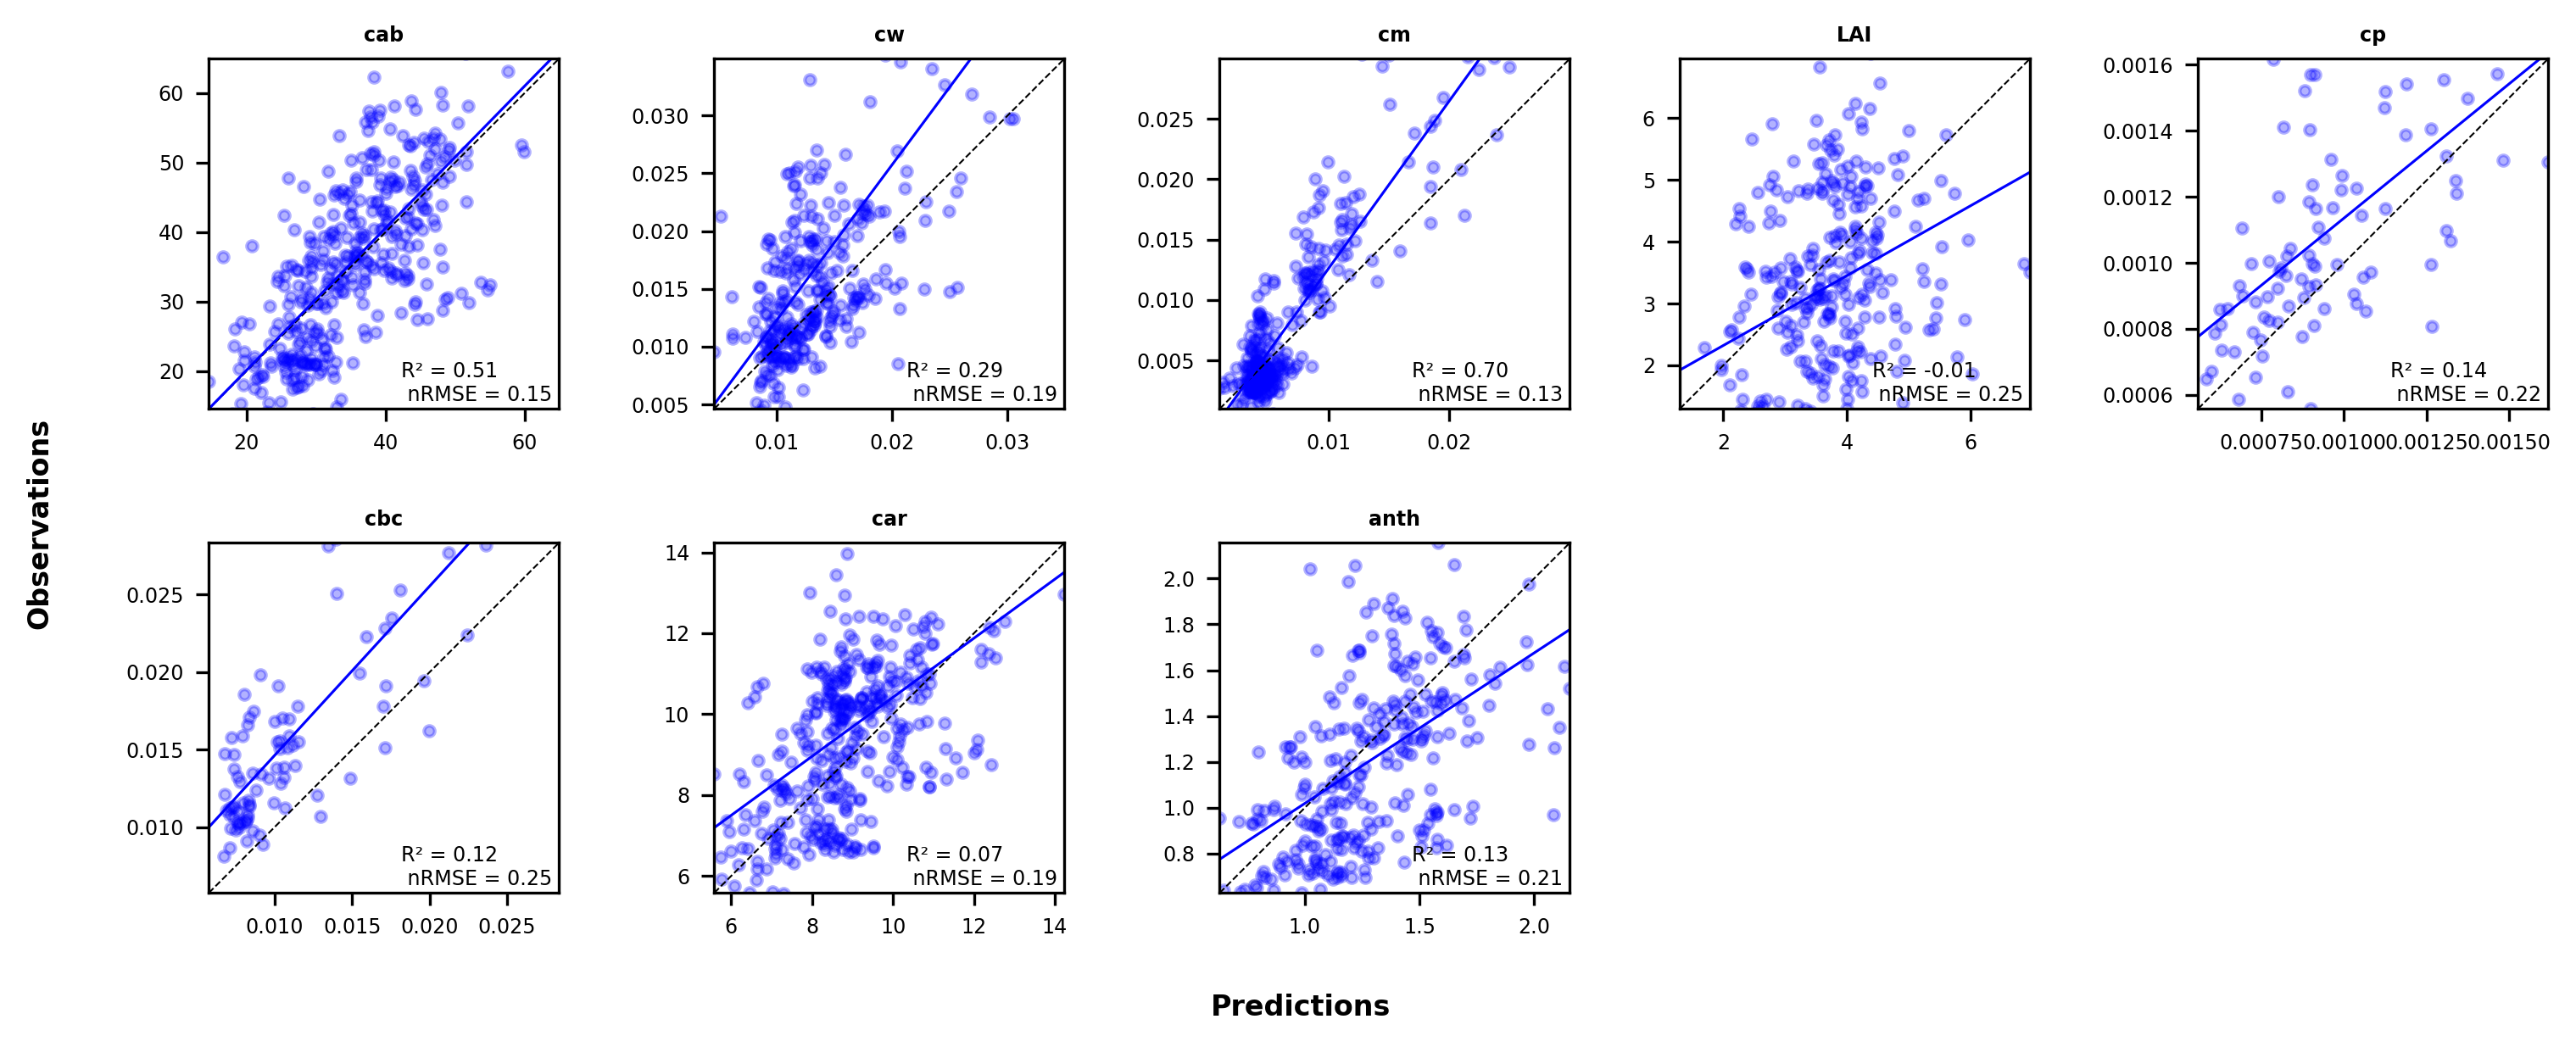

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import math
import seaborn as sns

size = 5.7
quantile_vis = 1.0
# test_tr = Traits[:-1]
figsize = (10,4)

# obs_pf = val_y
test_tr = list(ori_lb.columns)

plt.rc('font', size=size) #5.7
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.5

a = 2 # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = figsize,dpi=300 ,constrained_layout=True)


for tr in range(len(test_tr)):
    
    # test_sample = torch.tensor(val_x.astype(np.float32).values).unsqueeze(dim=1).to(gpu)
    # pred = scaler_list.inverse_transform(D(test_sample)[0].cpu().detach().numpy())[:,tr]
    # true = val_y[Traits[tr]]#val_y
    pred = df_tr_val.copy().values[:,tr]
    true = ori_lb.copy()[test_tr[tr]]
    
    norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))
    
    f = pd.DataFrame(pred)[0]
    y = true.reset_index(drop=True)
    
    idx = np.union1d(f[f.isna()].index,y[y.isna()].index)
    
    f.drop(idx, axis = 0, inplace=True)
    y.drop(idx, axis = 0, inplace=True)
    
    r2 = r2_score(y,f)
    nrmse = math.sqrt(mean_squared_error(y,f))/norm
    nmae = mean_absolute_error(y,f)/norm

    ax1 = plt.subplot(a, b, c)
    plt.axis('square')
    
    lim_max = min(f.quantile(quantile_vis),y.quantile(quantile_vis)) 
    lim_min = max(f.quantile(1-quantile_vis),y.quantile(1-quantile_vis))
    
    #######
    ax1.set_xlim(lim_min,lim_max)
    ax1.set_ylim(ax1.get_xlim())
    ax1.set_aspect('equal', adjustable='box')

    sns.lineplot(x=(lim_min,lim_max), y=(lim_min,lim_max), ax = ax1, color='black',legend='full', linestyle='dashed')

    sns.regplot(x= f, color='b', y=y,fit_reg= True,ax=ax1, ci=False, scatter_kws={"color": "blue", 'alpha':0.3})
    # sns.regplot(x= f, y=y, color='b', fit_reg= True, ax=ax1, scatter=False)

    ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    
    ax1.annotate(ann,
    xy=(0.55,0.01),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='bottom',size=size)

    ann = test_tr[tr]
    ax1.set_title(ann, y=1.1, pad=-5, fontdict = {'fontsize':size,
    'horizontalalignment': 'center', 'fontweight':'bold'})
    
    plt.xlabel(" ")
    plt.ylabel(" ")
    
    c+=1

fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
fig.supylabel('Observations', size=8, fontweight='bold', ha='center')